In [42]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
import joblib

In [43]:
# Load the dataset
df = pd.read_csv("data/water_potability.csv")

In [44]:
# Initial exploration
print("Dataset shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)

Dataset shape: (3276, 10)

Missing values:
 ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

Data types:
 ph                 float64
Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
Potability           int64
dtype: object


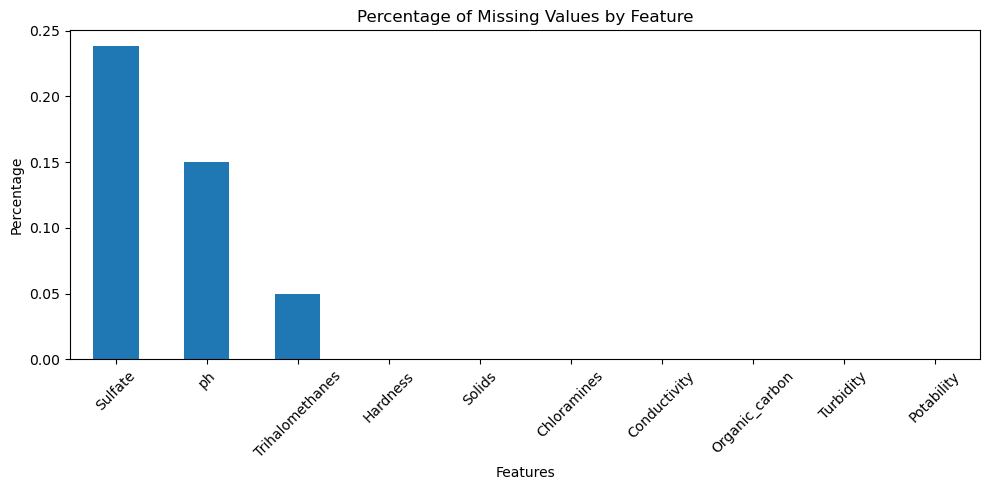

In [45]:
# Visualize missing values
plt.figure(figsize=(10, 5))
df.isnull().mean().sort_values(ascending=False).plot.bar()
plt.title("Percentage of Missing Values by Feature")
plt.ylabel("Percentage")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [46]:
# Handle missing values
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if col in ['ph', 'Sulfate', 'Trihalomethanes']:
            df[col] = df[col].fillna(df[col].median())

In [47]:
# Feature engineering
df['TDS_to_Hardness'] = df['Solids'] / df['Hardness']
df['Chloramine_to_Trihalomethanes'] = df['Chloramines'] / df['Trihalomethanes']

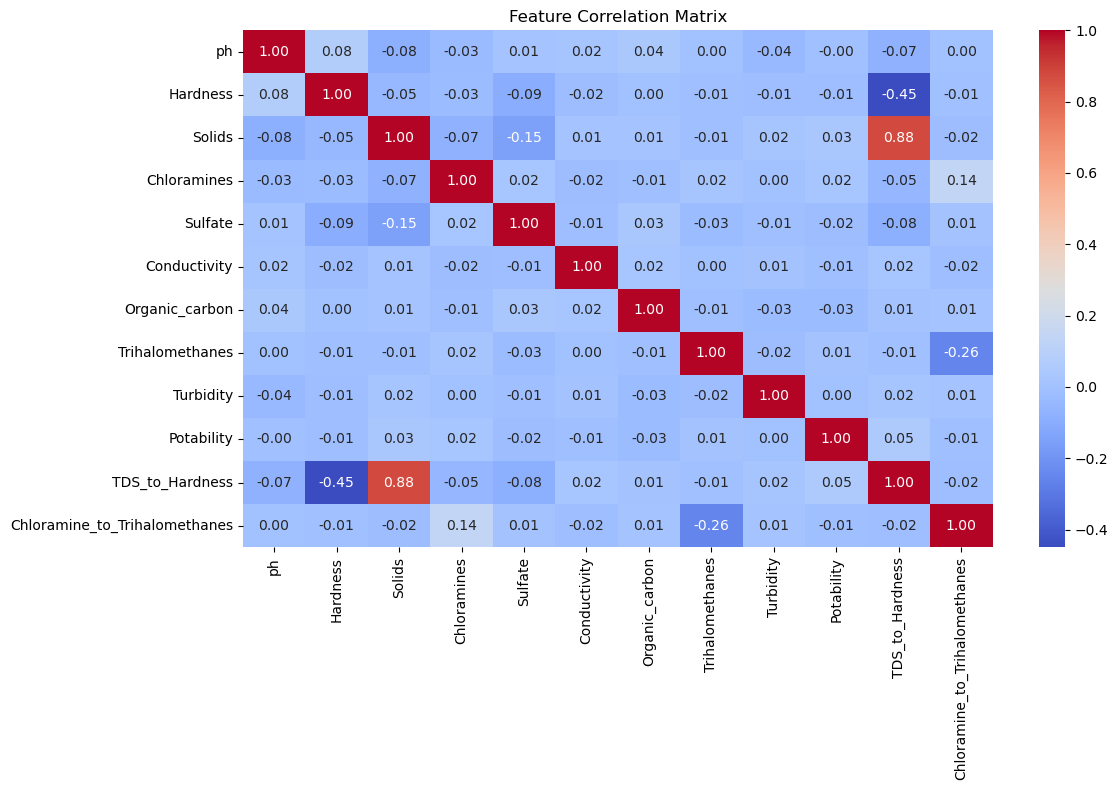

In [48]:
# Visualize correlations
plt.figure(figsize=(12, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

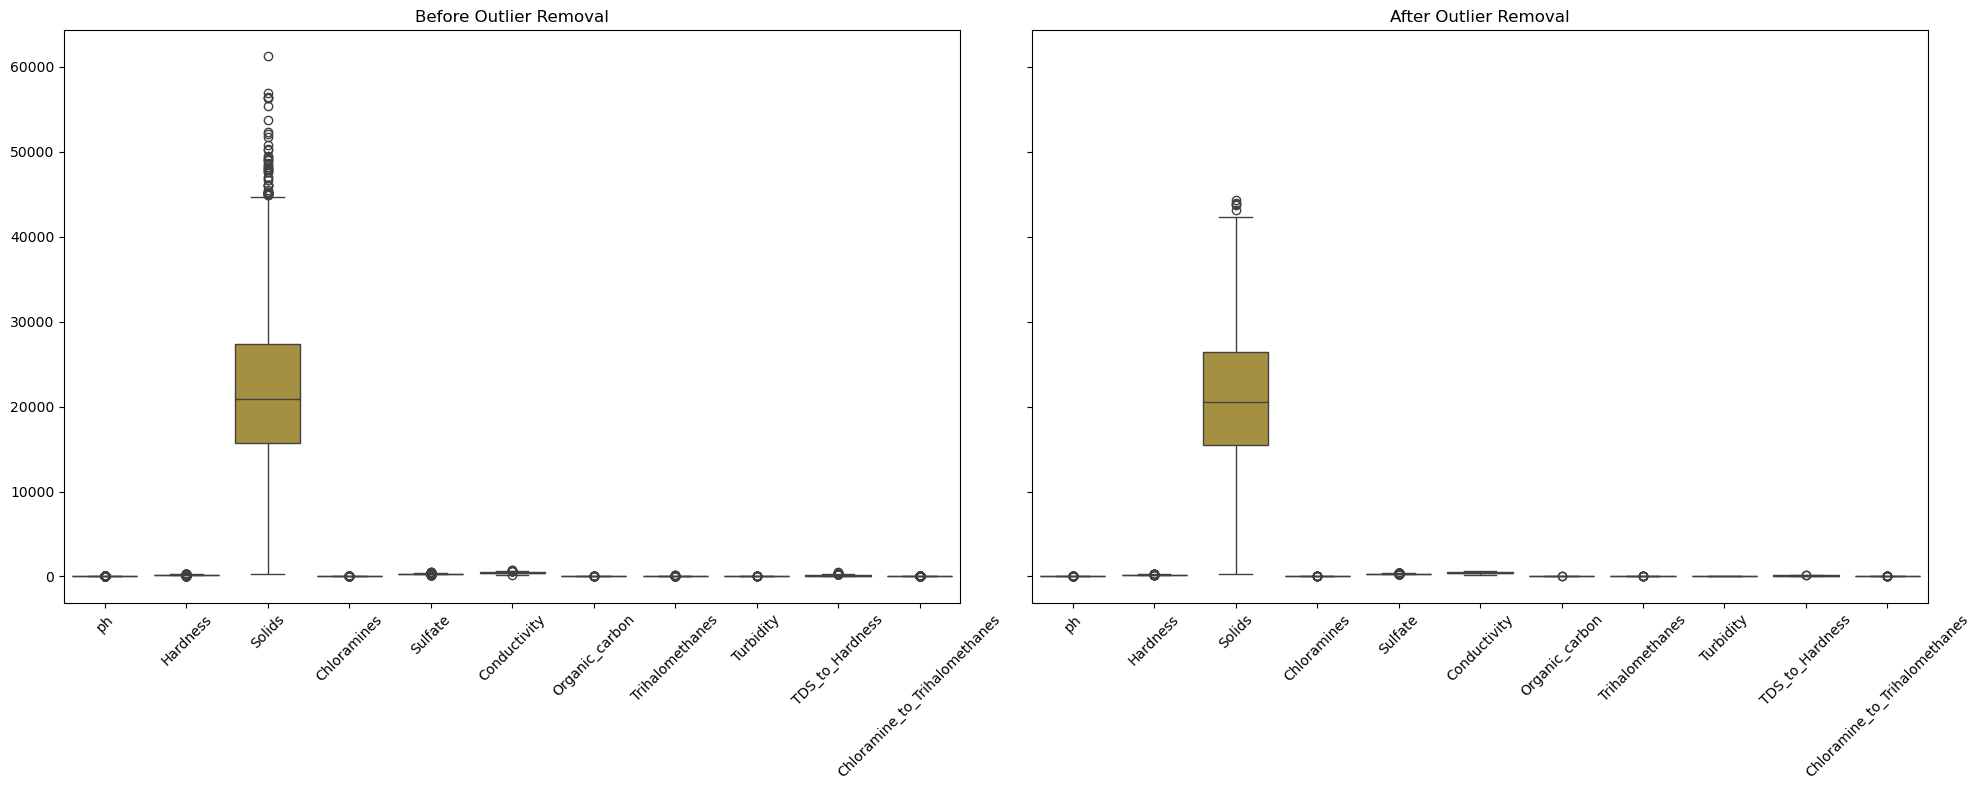

In [49]:
# Store original for comparison
df_original = df.copy()

# Outlier removal function
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[~((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))]
    return df

# Identify numerical columns
numerical_cols = df.select_dtypes(include=['float64']).columns.tolist()

# Remove outliers
df_no_outliers = remove_outliers(df_original, numerical_cols)

# Plotting side-by-side boxplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Before
sns.boxplot(data=df_original[numerical_cols], ax=axes[0])
axes[0].set_title("Before Outlier Removal")
axes[0].tick_params(axis='x', rotation=45)

# After
sns.boxplot(data=df_no_outliers[numerical_cols], ax=axes[1])
axes[1].set_title("After Outlier Removal")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [50]:
print("Before outlier removal:", df_original.shape)
print("After outlier removal:", df_no_outliers.shape)


Before outlier removal: (3276, 12)
After outlier removal: (2525, 12)


In [51]:
def remove_outliers_verbose(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        before = df.shape[0]
        df = df[(df[col] >= lower) & (df[col] <= upper)]
        after = df.shape[0]
        print(f"{col}: Removed {before - after} rows")
    return df

df_no_outliers = remove_outliers_verbose(df_original.copy(), numerical_cols)


ph: Removed 142 rows
Hardness: Removed 74 rows
Solids: Removed 41 rows
Chloramines: Removed 52 rows
Sulfate: Removed 229 rows
Conductivity: Removed 7 rows
Organic_carbon: Removed 15 rows
Trihalomethanes: Removed 41 rows
Turbidity: Removed 18 rows
TDS_to_Hardness: Removed 38 rows
Chloramine_to_Trihalomethanes: Removed 94 rows


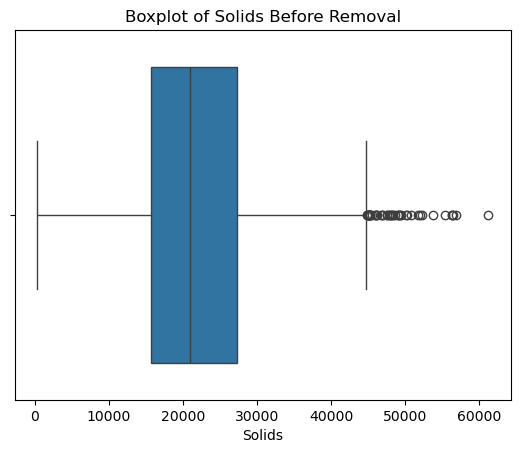

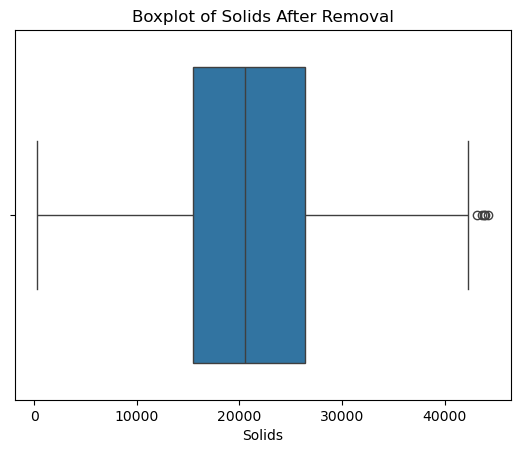

In [52]:
col = 'Solids'  # Change to any column you're interested in
sns.boxplot(x=df_original[col])
plt.title(f'Boxplot of {col} Before Removal')
plt.show()

sns.boxplot(x=df_no_outliers[col])
plt.title(f'Boxplot of {col} After Removal')
plt.show()


ph: Removed 142 rows
Hardness: Removed 74 rows
Solids: Removed 41 rows
Chloramines: Removed 52 rows
Sulfate: Removed 229 rows
Conductivity: Removed 7 rows
Organic_carbon: Removed 15 rows
Trihalomethanes: Removed 41 rows
Turbidity: Removed 18 rows
Potability: Removed 0 rows
TDS_to_Hardness: Removed 38 rows
Chloramine_to_Trihalomethanes: Removed 94 rows


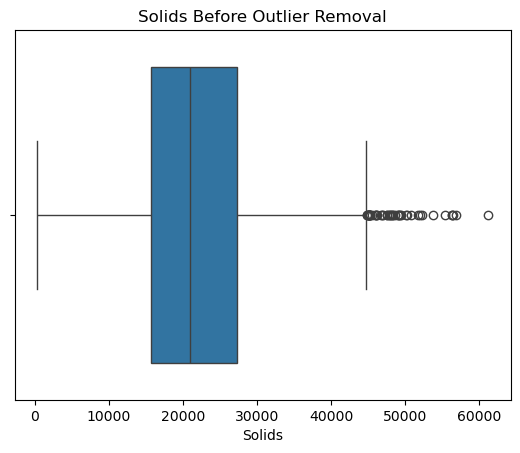

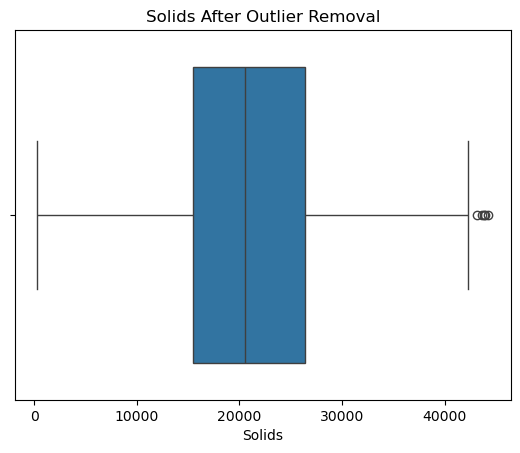

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Outlier removal function
def remove_outliers_columnwise(df, columns):
    df_cleaned = df.copy()
    for col in columns:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        before = df_cleaned.shape[0]
        df_cleaned = df_cleaned[(df_cleaned[col] >= lower) & (df_cleaned[col] <= upper)]
        after = df_cleaned.shape[0]
        print(f"{col}: Removed {before - after} rows")
    return df_cleaned

# Select numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Save original
df_original = df.copy()

# Remove outliers
df_no_outliers = remove_outliers_columnwise(df_original, numerical_cols)

# Plot comparison for a specific column (e.g., 'Solids')
col = 'Solids'

# Before
sns.boxplot(x=df_original[col])
plt.title(f'{col} Before Outlier Removal')
plt.show()

# After
sns.boxplot(x=df_no_outliers[col])
plt.title(f'{col} After Outlier Removal')
plt.show()

In [61]:
# Select numerical and categorical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

def plot_3x3_grid(columns, before_func, after_func=None, title=""):
    total = len(columns)
    cols_per_row = 3
    rows = (total + cols_per_row - 1) // cols_per_row
    fig, axes = plt.subplots(rows, cols_per_row * (2 if after_func else 1), figsize=(5 * cols_per_row * (2 if after_func else 1), 4 * rows))
    fig.suptitle(title, fontsize=18)

    for i, col in enumerate(columns):
        r = i // cols_per_row
        c = i % cols_per_row

        if after_func:
            ax1 = axes[r][c * 2] if rows > 1 else axes[c * 2]
            ax2 = axes[r][c * 2 + 1] if rows > 1 else axes[c * 2 + 1]
            before_func(col, ax1)
            ax1.set_title(f"{col} (Before)")
            after_func(col, ax2)
            ax2.set_title(f"{col} (After)")
        else:
            ax = axes[r][c] if rows > 1 else axes[c]
            before_func(col, ax)
            ax.set_title(col)

    # Remove any unused subplots
    total_subplots = rows * cols_per_row * (2 if after_func else 1)
    for j in range(len(columns), total_subplots):
        r = j // (cols_per_row * (2 if after_func else 1))
        c = j % (cols_per_row * (2 if after_func else 1))
        if rows > 1:
            axes[r][c].axis('off')
        else:
            axes[c].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

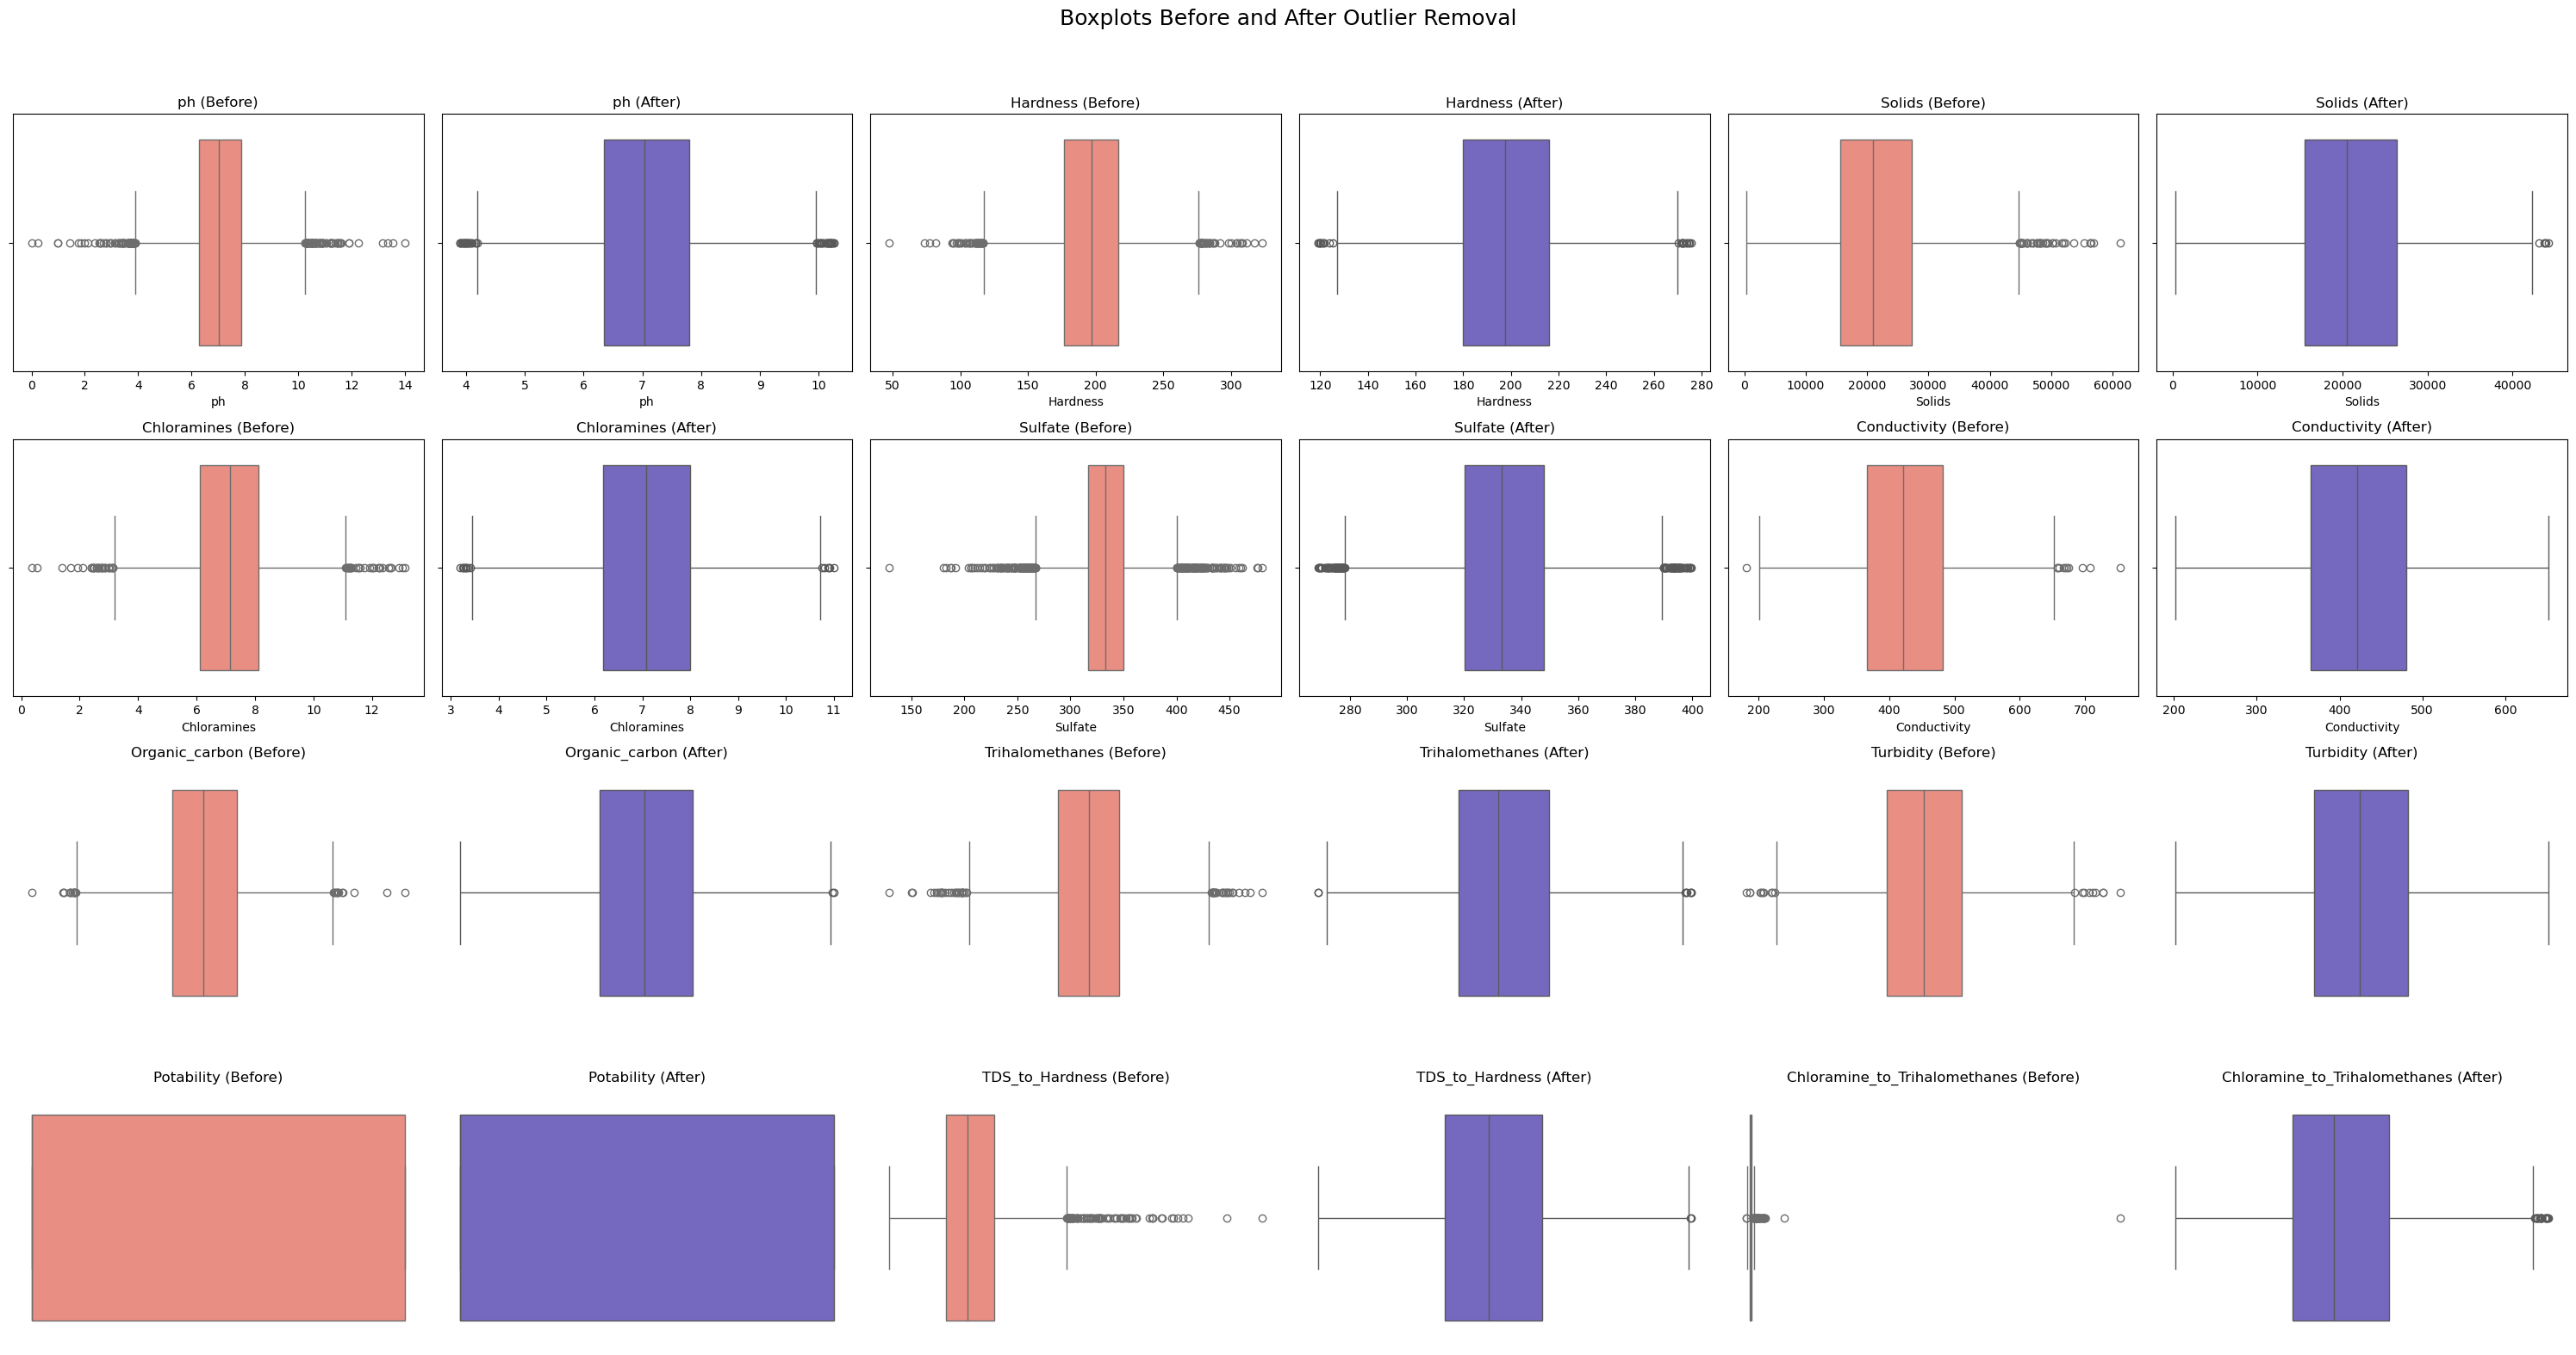

In [62]:
# Boxplot
plot_3x3_grid(
    numerical_cols,
    lambda col, ax: sns.boxplot(x=df[col], ax=ax, color='salmon'),
    lambda col, ax: sns.boxplot(x=df_no_outliers[col], ax=ax, color='slateblue'),
    "Boxplots Before and After Outlier Removal"
)

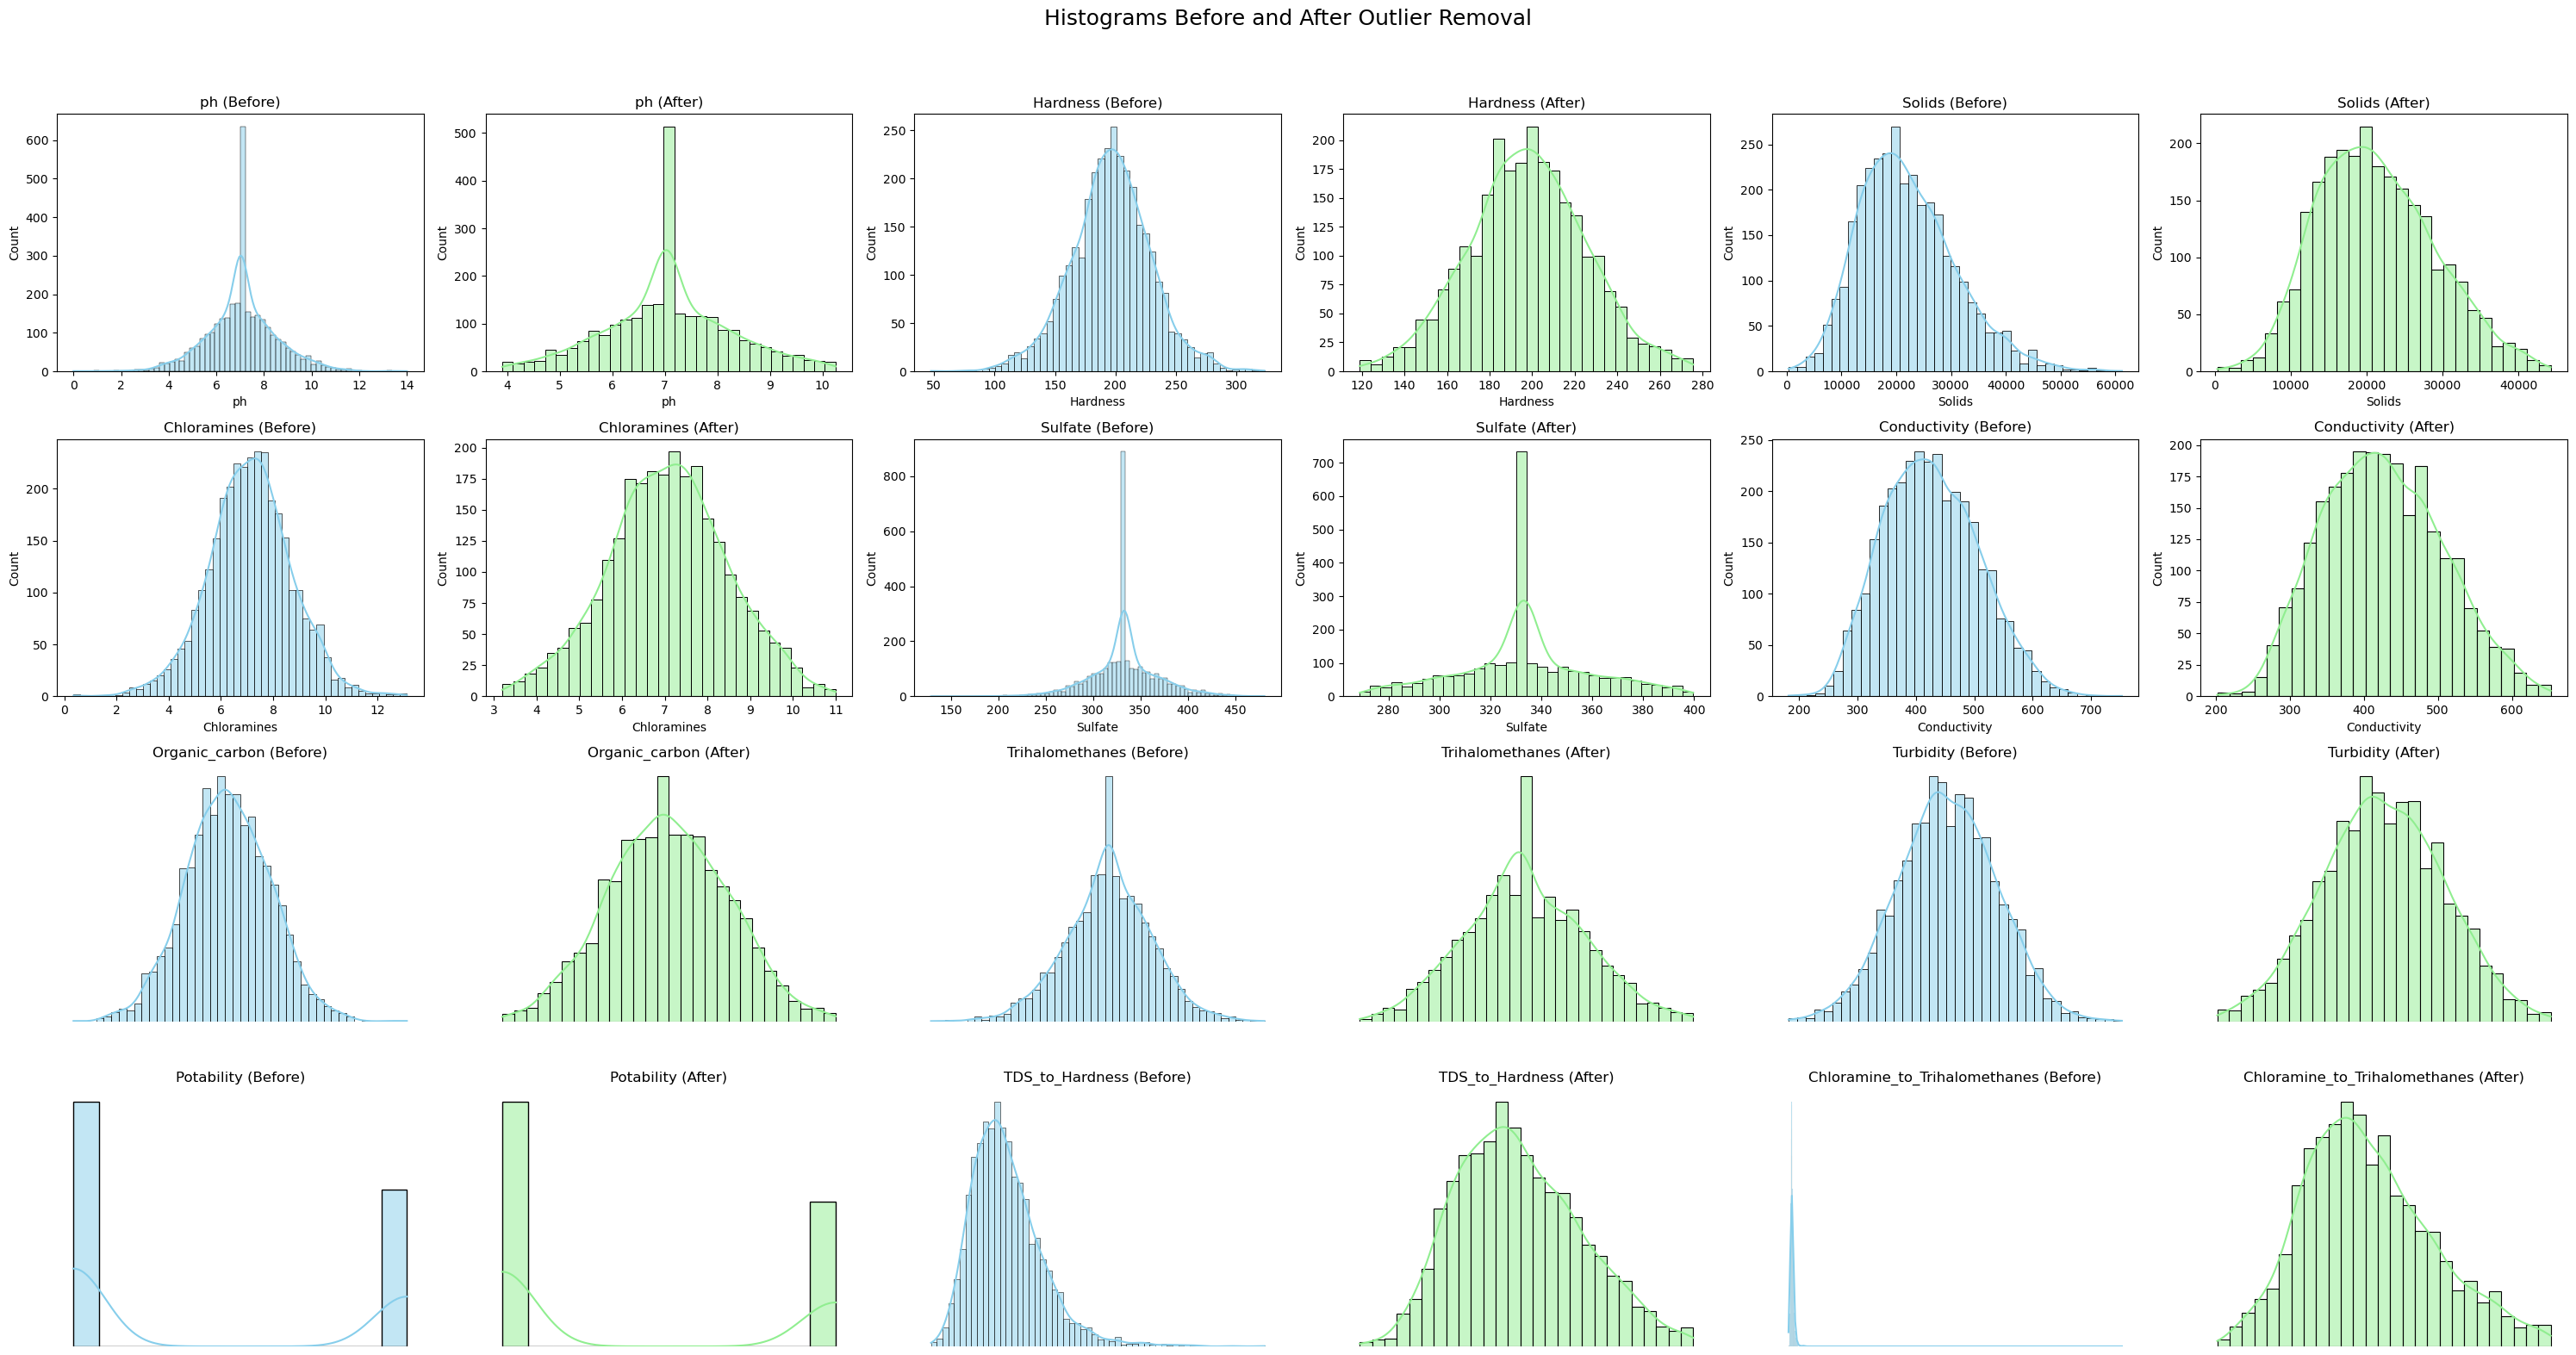

In [63]:
# Histogram
plot_3x3_grid(
    numerical_cols,
    lambda col, ax: sns.histplot(df[col], kde=True, ax=ax, color='skyblue'),
    lambda col, ax: sns.histplot(df_no_outliers[col], kde=True, ax=ax, color='lightgreen'),
    "Histograms Before and After Outlier Removal"
)

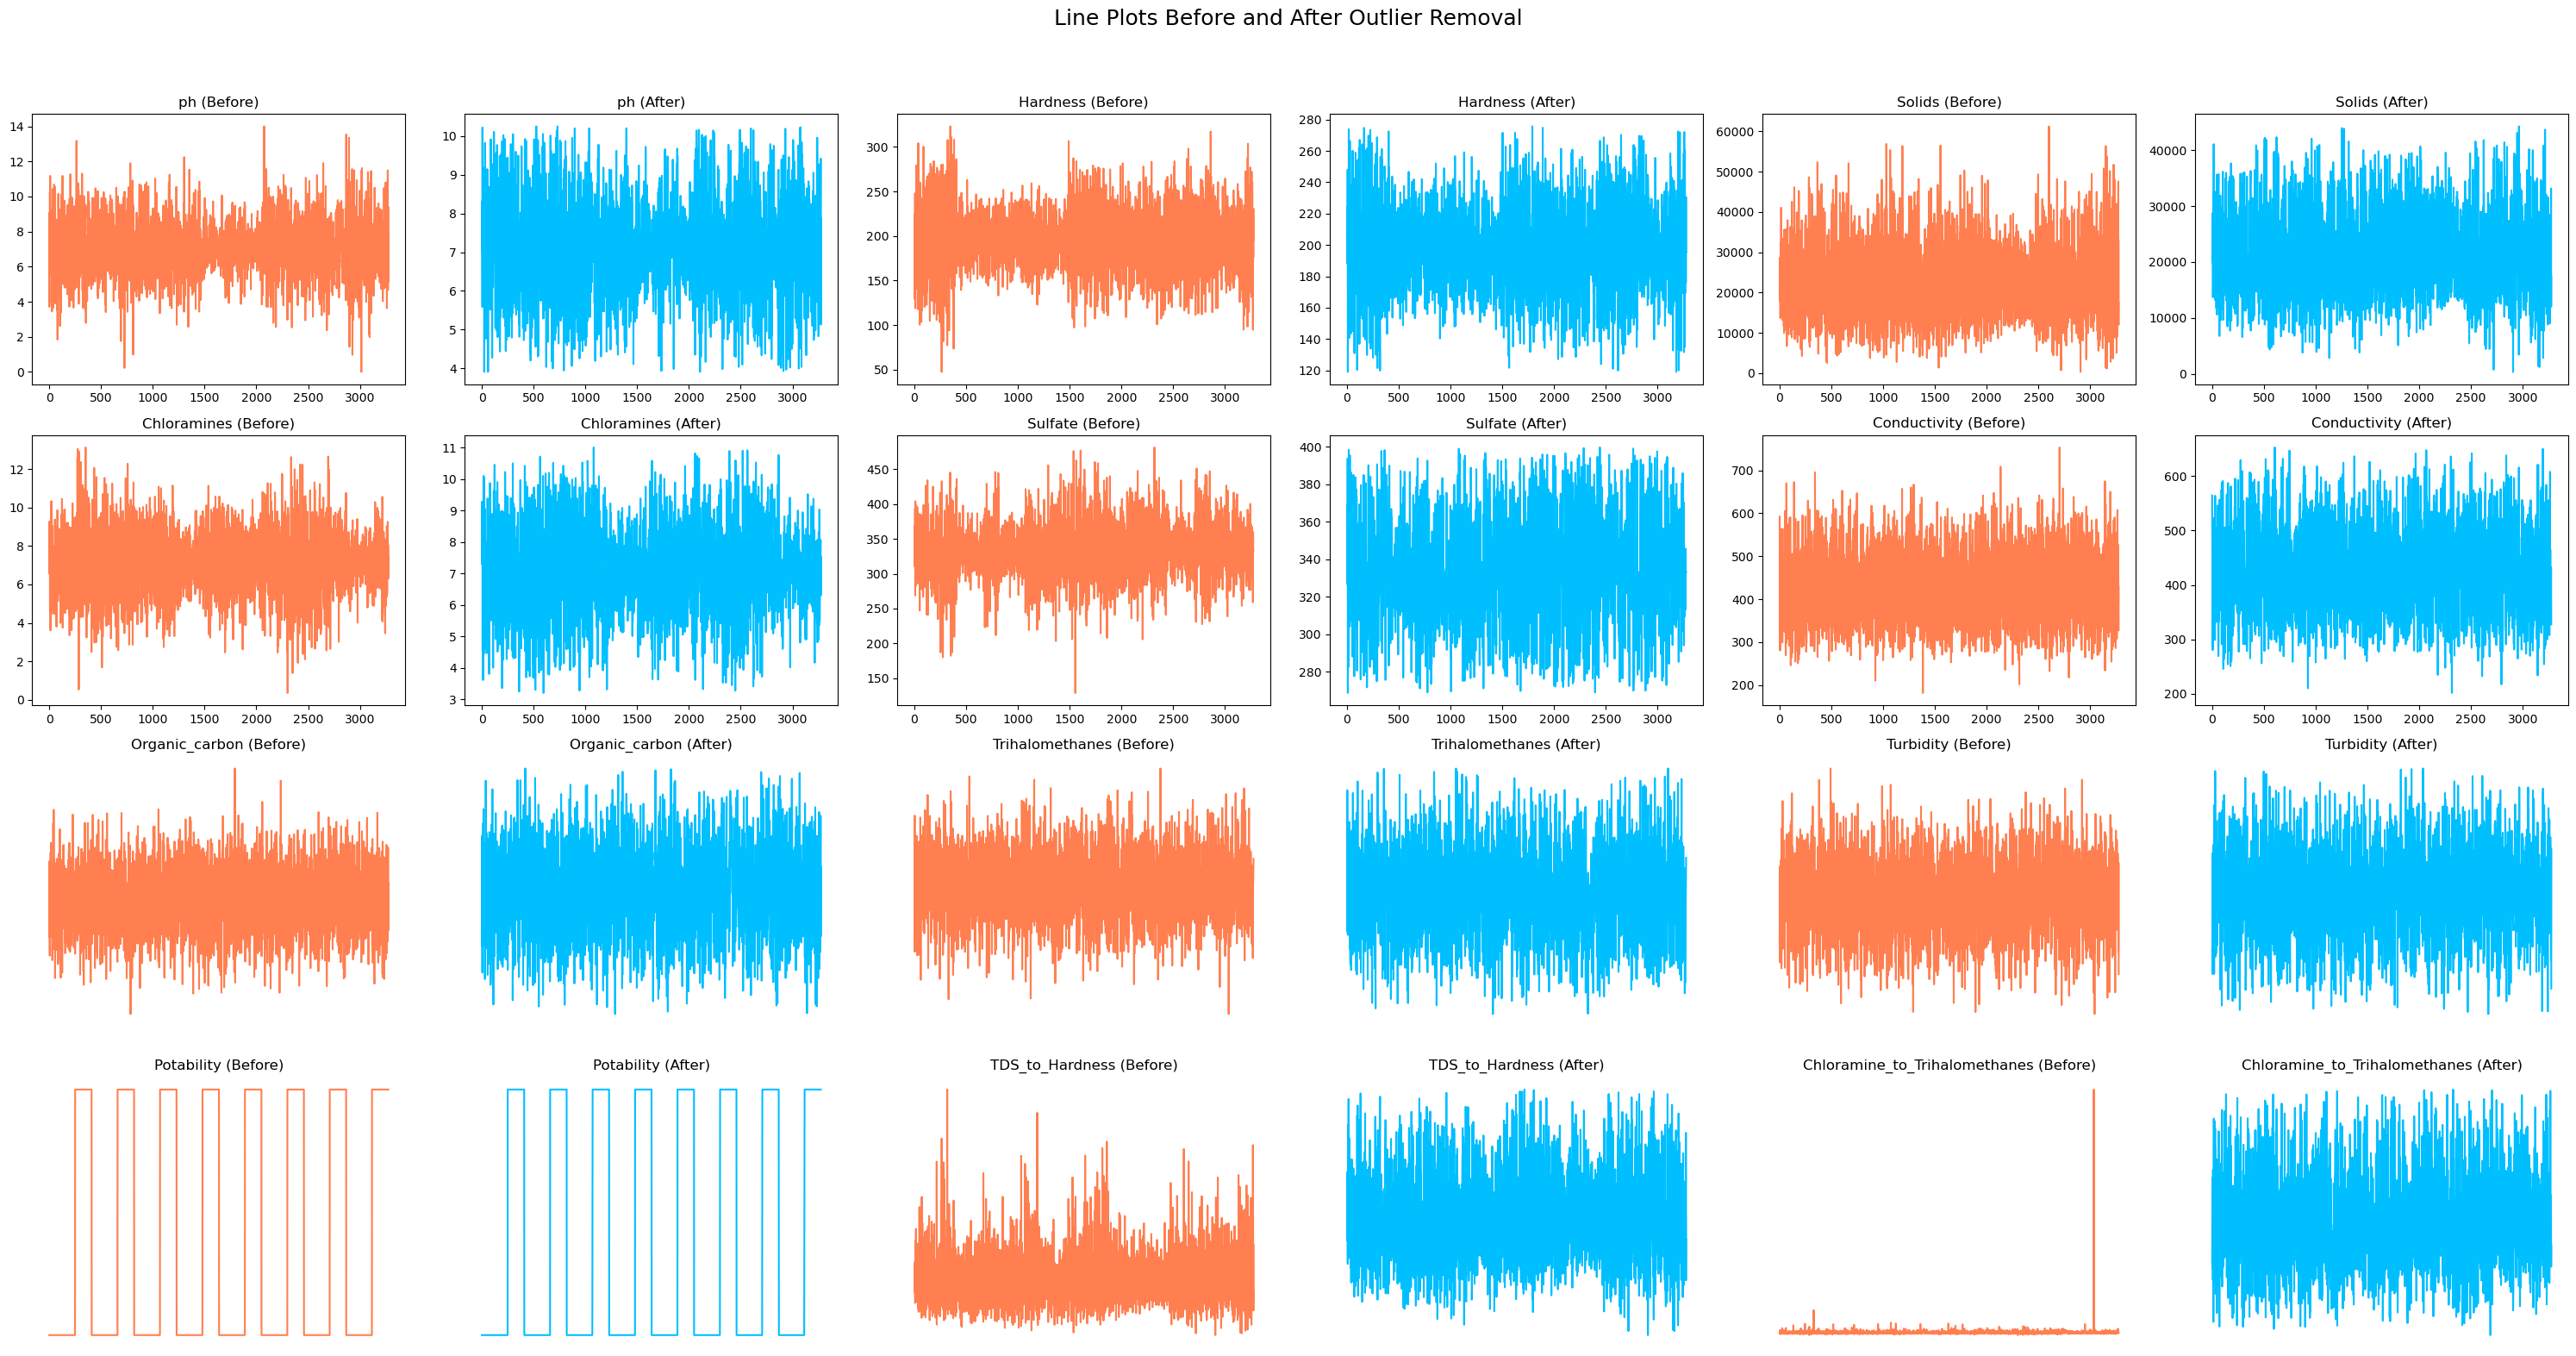

In [64]:
# Lineplot
plot_3x3_grid(
    numerical_cols,
    lambda col, ax: ax.plot(df[col], color='coral'),
    lambda col, ax: ax.plot(df_no_outliers[col], color='deepskyblue'),
    "Line Plots Before and After Outlier Removal"
)

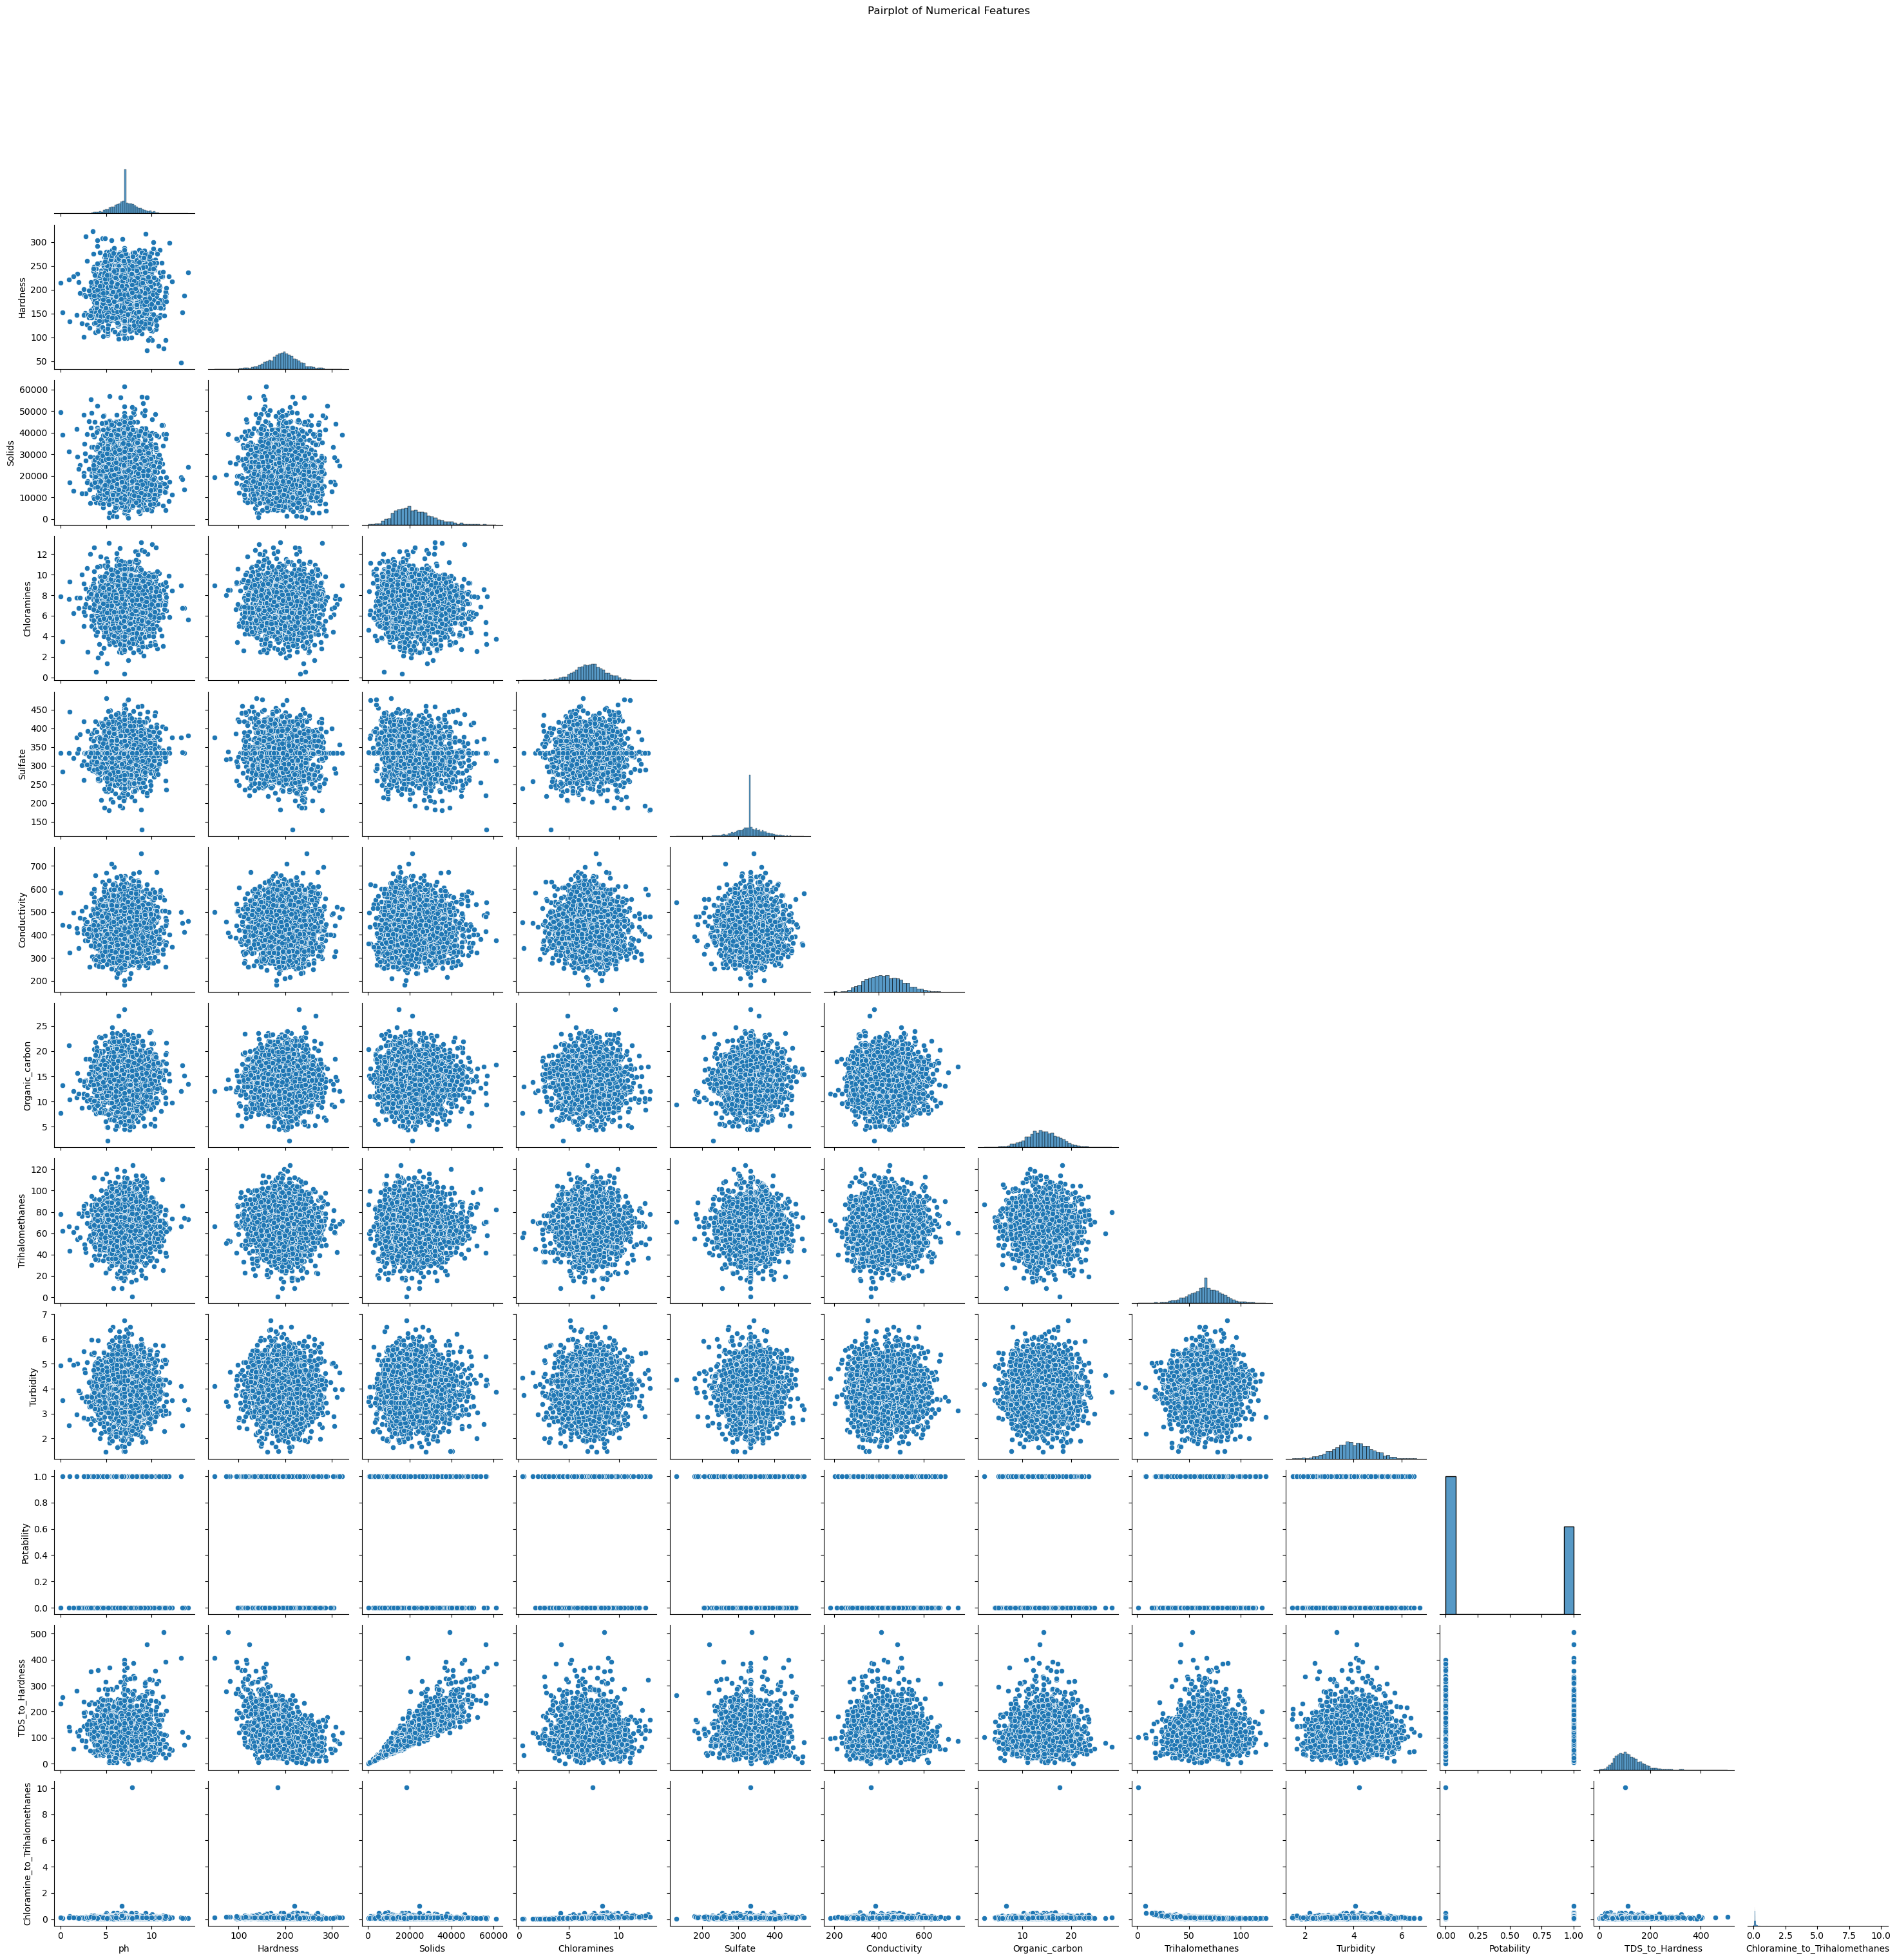

In [70]:
# PairPlot
sns.pairplot(df[numerical_cols], corner=True)
plt.suptitle("Pairplot of Numerical Features", y=1.02)
plt.show()

In [33]:
# Prepare data for modeling
X = df.drop('Potability', axis=1)
y = df['Potability']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [34]:
# Scale numerical features
scaler = StandardScaler()
cols_to_scale = ['Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 
                 'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'TDS_to_Hardness',
                 'Chloramine_to_Trihalomethanes']

X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

In [35]:
# Train Random Forest with hyperparameter tuning
rf_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=rf_params, 
                              n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 15, 20, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, verbose=2)

In [36]:
# Evaluate Random Forest
best_rf = rf_random.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("Random Forest Results:")
print("Best Parameters:", rf_random.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Results:
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': True}
Accuracy: 0.6661585365853658

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.91      0.77       400
           1       0.67      0.29      0.40       256

    accuracy                           0.67       656
   macro avg       0.67      0.60      0.59       656
weighted avg       0.67      0.67      0.63       656



In [37]:
# Train Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [38]:
# Evaluate Naive Bayes
y_pred_gnb = gnb.predict(X_test)
print("\nNaive Bayes Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_gnb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_gnb))


Naive Bayes Results:
Accuracy: 0.4222560975609756

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.08      0.14       400
           1       0.40      0.96      0.56       256

    accuracy                           0.42       656
   macro avg       0.57      0.52      0.35       656
weighted avg       0.61      0.42      0.31       656



In [40]:
# Save the best model and scaler
joblib.dump(gnb, "models/model.pkl")
joblib.dump(scaler, "models/scaler.pkl")

['models/scaler.pkl']

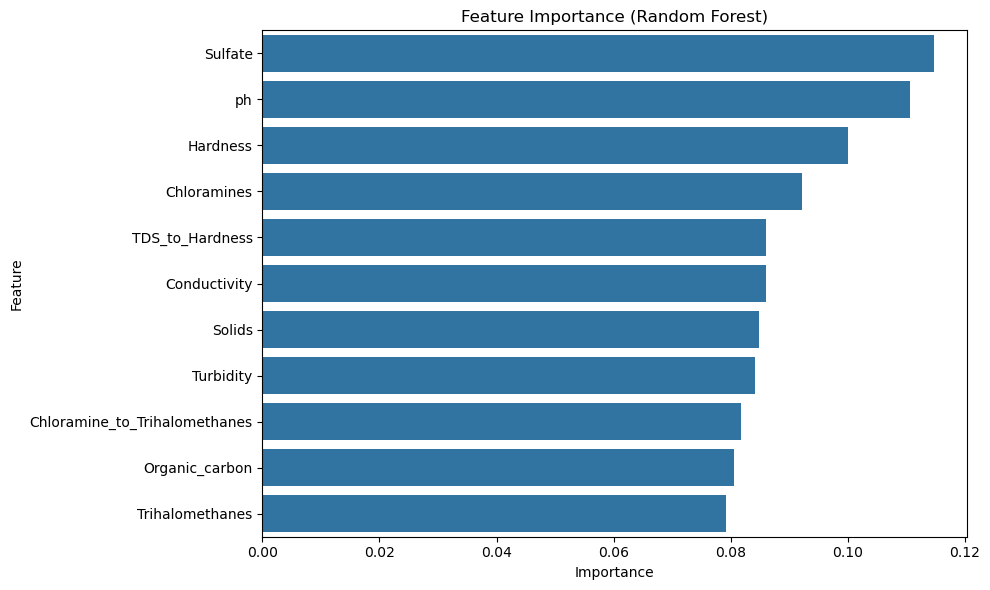

In [41]:
# Feature importance for Random Forest
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()